### Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import pybinding as pb
from pybinding.repository import graphene

from tqdm import tqdm

import psutil
import os

Create folder to save plots

In [27]:
!mkdir output

mkdir: cannot create directory ‘output’: File exists


Limit CPU to 75% so i can still use my pc

### Create the material and any defects

In [28]:
# Basis Vectors
a1 = graphene.a * np.array([1, np.sqrt(3)])/2
a2 = graphene.a * np.array([-1, np.sqrt(3)])/2
a3 = graphene.a * np.array([1, 0])

at = graphene.a/np.sqrt(3) # Distance between A and B sublattices

# Here we model the defect as a gaussian potential
# We can specify whether its at sublattice points or inbetween
# Duterix 2019 Defect is on sublattice A

def pv(x, y):
  #return -3*np.exp(-((1)*(x)**2+(1)*(y+at/2)**2)/(at)**2)
  #scalef = 100
  #return 100*np.exp(-scalef * ((1)*(x)**2+(1)*(y+at/2)**2)/(at)**2)
  return 0

def defect():
  @pb.onsite_energy_modifier
  def potential(x, y):
    #return -3*np.exp(-(x**2+(y-at/2)**2)/(at)**2)
    return pv(x, y)

  return potential

# Create tightbinding model
model = pb.Model(graphene.monolayer(), pb.rectangle(50, 50))
#model = pb.Model(graphene.monolayer(), pb.rectangle(50, 50))

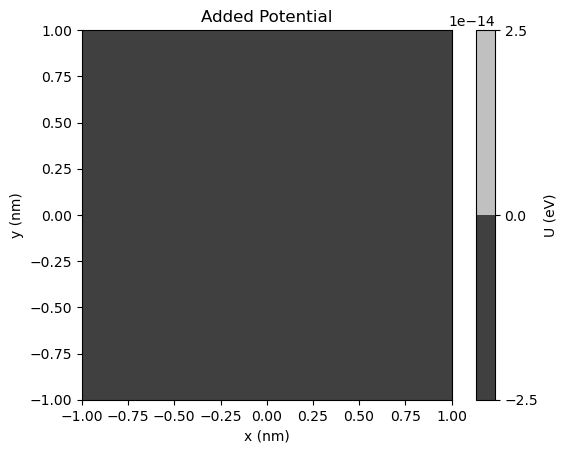

In [29]:
# Plotting defect potential
fig1, ax1 = plt.subplots()

x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)

xx, yy = np.meshgrid(x, y)
#zz = pv(xx, yy)
zz = xx * 0 #no defect

h = ax1.contourf(xx, yy, zz, cmap='gray')
ax1.set_title("Added Potential")
ax1.set_xlabel("x (nm)")
ax1.set_ylabel("y (nm)")
ax1.set_aspect("equal")
fig1.colorbar(h, label="U (eV)")

fig1.savefig("output/added_potential.png")

ValueError: Contour levels must be increasing

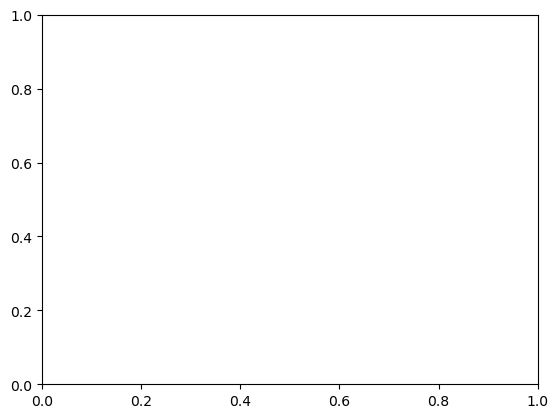

In [30]:
# Plotting energy ontop of lattice
model.onsite_map.plot_contourf()
pb.pltutils.colorbar(label="U (eV)")
model.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Defect on Lattice")

plt.savefig("output/defect_on_lattice.png")

ValueError: Contour levels must be increasing

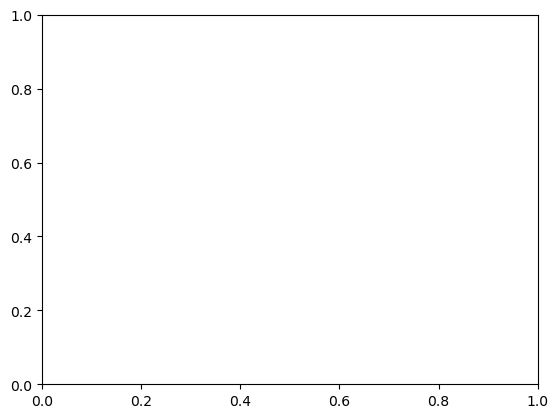

In [31]:
# Plotting energy ontop of lattice
model.onsite_map.plot_contourf()
pb.pltutils.colorbar(label="U (eV)")
model.plot()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Defect on Lattice")

plt.savefig("output/defect_on_lattice_zoom.png")

### LDOS with KPM

[0. 0.]
[-1.22975     2.12998948]


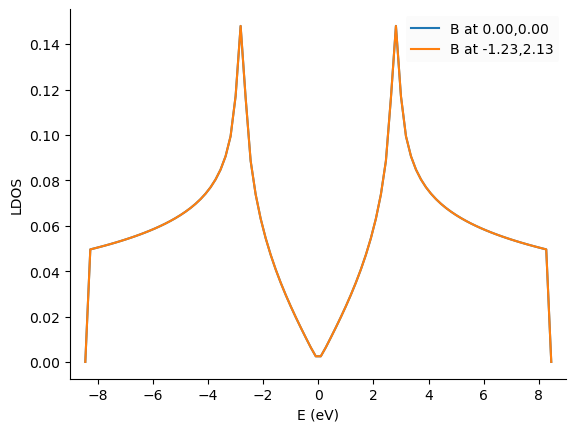

In [32]:
kpm = pb.kpm(model) # Kernal polynomial method. Instead of diagonalizing, explands everything in terms of Chebyshev polynomials

# Calculate LDOS close and far away
positions = [a1 * 0, a2 * 10]
sublattices = ['B', 'B'] # Which sub lattice we want to calculate for

for p, s in zip(positions, sublattices):
  print(p)
  ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 100), broadening=0.1, position=p, sublattice=s)
  ldos.plot(label=s + " at {pa:.2f},{pb:.2f}".format(pa=p[0], pb=p[1]))

pb.pltutils.legend()

plt.savefig("output/energy_ldos.png")

### Discrete Spatial LDOS at fixed energy

In [33]:
size = 20 # half of lateral size
energies = np.array([0.2]) # eV

spatial_ldos = kpm.calc_spatial_ldos(np.linspace(-3, 3, 100),
                                     broadening=0.1, #eV
                                     shape=pb.rectangle(size*2))

Computing KPM moments...
Progress  0% [                                ] Elapsed: 0:00:00 / ETA: --:--:--

Progress 100% [////////////////////////////////] Elapsed: 0:03:29 / ETA: 0:00:00


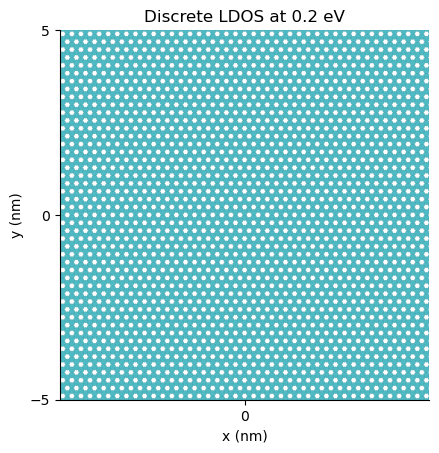

In [34]:
# Plotting
fig2, ax2 = plt.subplots()

smap = spatial_ldos.structure_map(energies[0])
smap.plot(site_radius=(0.02, 0.15))
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_xlabel("x (nm)")
ax2.set_ylabel("y (nm)")
ax2.set_title("Discrete LDOS at 0.2 eV")

fig2.savefig("output/discrete_ldos.png")

### Continuous Spatial LDOS

In [35]:
(X, Y, Z) = smap.spatial_map.positions
psi2 = smap.data

mesh_size = 1000
x, y = np.meshgrid(np.linspace(-size, size, mesh_size),
                   np.linspace(-size, size, mesh_size))
z = x*0

# Interpolate by gaussian
# Every site impacts the points like a gaussian
# See Slater-Koster tightbinding for graphene band structure
for (X, Y, psi2) in tqdm(zip(X, Y, psi2)):
  z += psi2*np.exp(-((x-X)**2+(y-Y)**2)/(at)**2)

z_min, z_max = 0, np.abs(z).max()

61100it [17:35, 57.90it/s]


In [36]:
np.min(np.abs(z))

0.003596018968048658

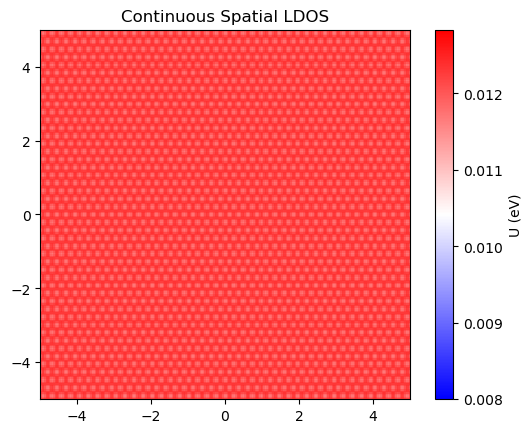

In [40]:
fig3, ax3 = plt.subplots()

c = ax3.pcolormesh(x, y, np.abs(z), cmap='bwr', vmin=0.008, vmax=z_max)
ax3.axis([x.min(), x.max(), y.min(), y.max()])
fig3.colorbar(c, ax=ax3, label="U (eV)")
ax3.set_aspect("equal")
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)

ax3.set_title("Continuous Spatial LDOS")
fig3.savefig("output/continuous_ldos.png")

In [38]:
df = pd.DataFrame()

df['x'] = x.flatten()
df['y'] = y.flatten()
df['Re(z)'] = np.real(z).flatten()
df['Im(z)'] = np.imag(z).flatten()
df['MeshSize'] = mesh_size
df['DiscreteSize'] = size
df['LDOS Energy'] = energies[0]

df.to_csv("output/continous_ldos.csv")